# Experiment: Water Management Strategies: Water Treatment



In [15]:
import math
import os
import sys

sys.path.insert(1, os.path.abspath(os.getcwd()[:-3]))

from src.aquastat_utils import *

# Import AQUASTAT
aquastat_df = get_aquastat()

Getting AQUASTAT dataframe from fao_aquastat.csv ...
C:\Users\simon\DataspellProjects\team-acqua\src\..\dat\fao_aquastat.csv already exists.
Renaming countries ...


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles
import scipy.stats as stats

plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({"figure.dpi": 300})

### Check available Data for inconsistencies
There are multiple municipal wastewater variables. To check their consistencies we should check if they correspond to one another.

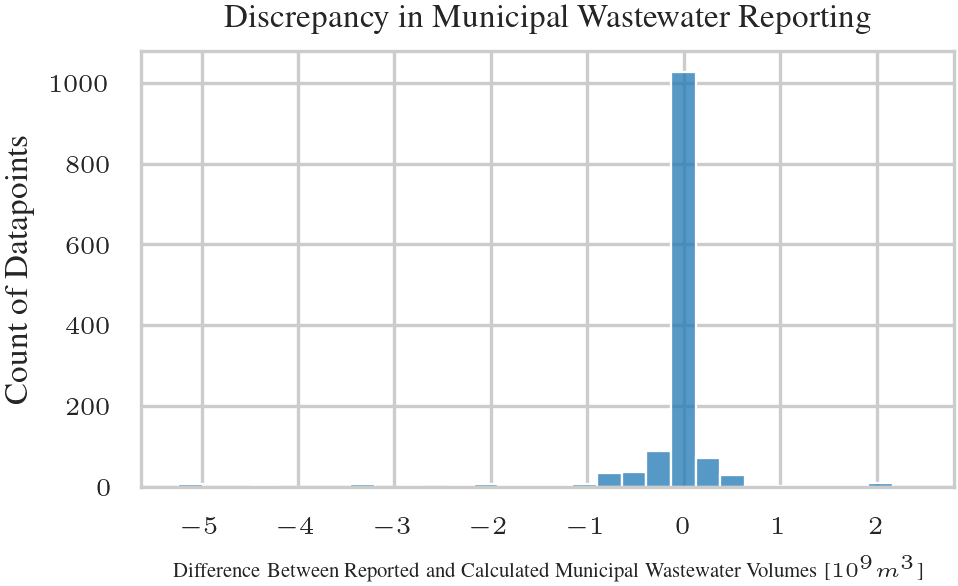

In [17]:
test_df = aquastat_df[['Country', 'Year', 'Treated municipal wastewater', 'Not treated municipal wastewater',
                       'Produced municipal wastewater']].dropna()

test_df['Difference'] = test_df['Produced municipal wastewater'] - (
            test_df['Treated municipal wastewater'] + test_df['Not treated municipal wastewater'])

sns.histplot(data=test_df, x='Difference', bins=30)
plt.title('Discrepancy in Municipal Wastewater Reporting')
plt.xlabel('Difference Between Reported and Calculated Municipal Wastewater Volumes [$10^9 m^3$]', fontsize='5')
plt.ylabel('Count of Datapoints')
plt.show()

For the overwhelming majority of the dataset the sum of treated and non-treated municipal wastewater is very close to the produced municipal wastewater.

### Fix Data

In [18]:
aquastat_df.loc[(aquastat_df['Country'] == 'Denmark') & (aquastat_df['Year'] >= 2011) & (aquastat_df['Year'] <= 2014), 'Produced municipal wastewater'] /= 1000

### Examine treated municiple water share

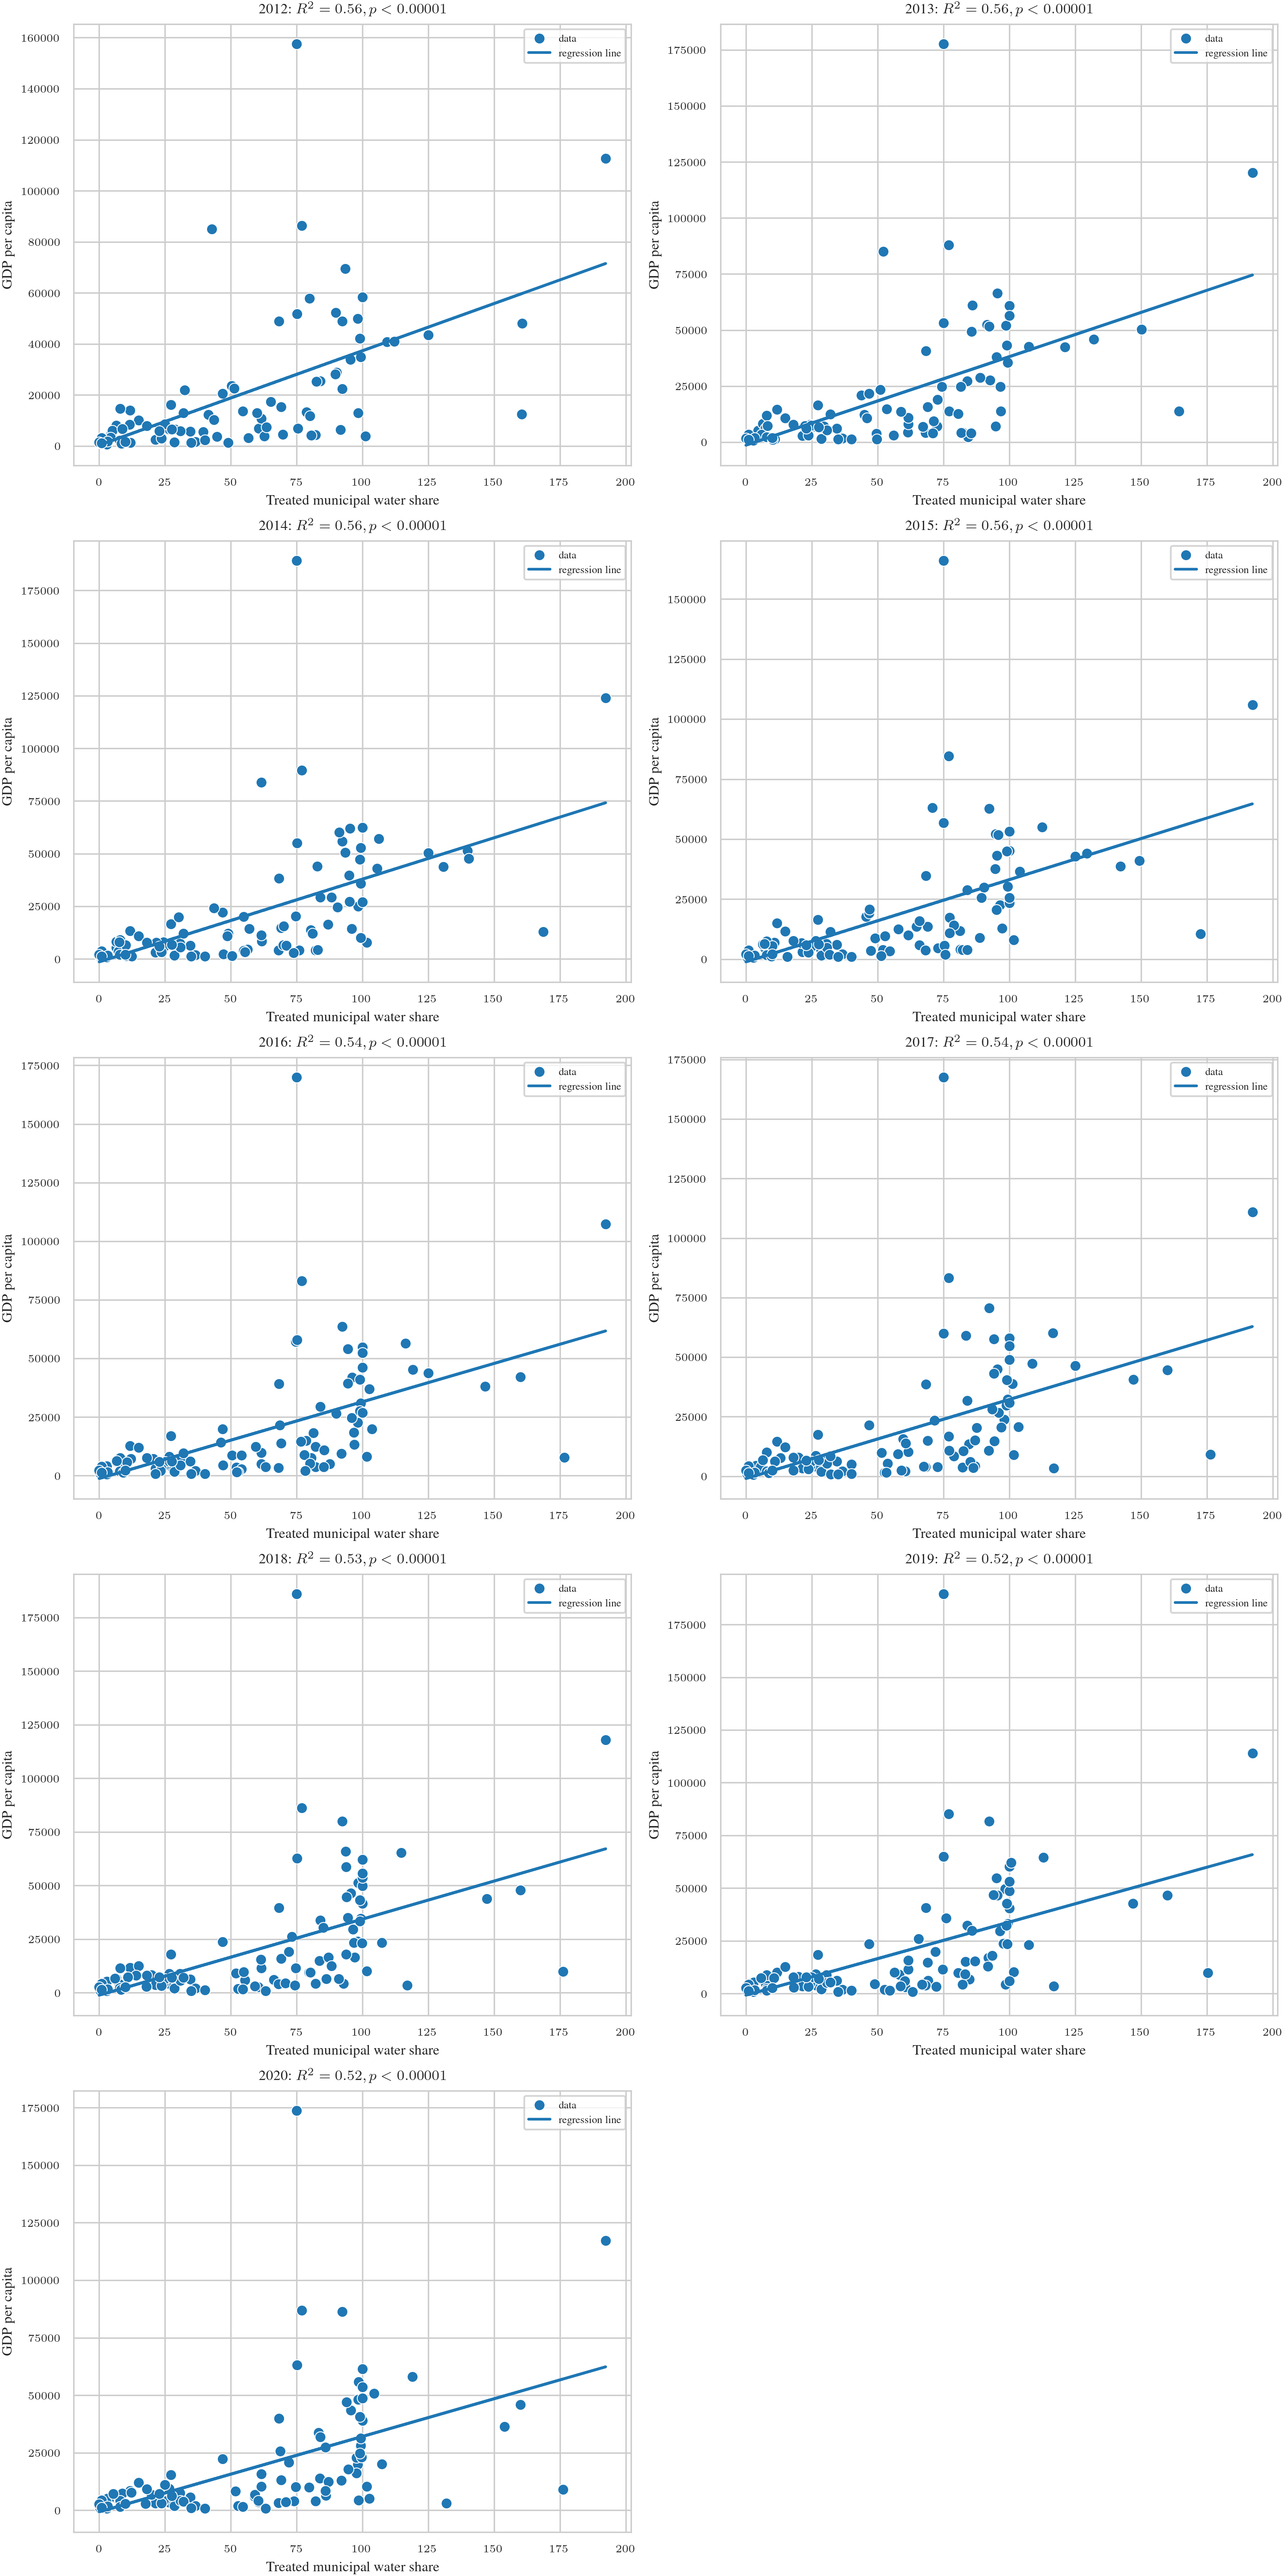

In [19]:
wastewater_df = aquastat_df[
    ['Country', 'Year', 'Treated municipal wastewater', 'Produced municipal wastewater']].dropna()
wastewater_df['Treated municipal water share'] = (wastewater_df['Treated municipal wastewater'] / wastewater_df[
    'Produced municipal wastewater']) * 100
wastewater_df = wastewater_df[wastewater_df['Treated municipal water share'] < 200]

regression_var = 'GDP per capita'
wastewater_df[regression_var] = aquastat_df[regression_var]
wastewater_df = wastewater_df.dropna()

start = 2012
years = wastewater_df[wastewater_df['Year'] >= 2012]['Year'].unique()
years.sort()
n = len(years)
width = min(2, n)
height = math.ceil(n / width)

fig, axes = plt.subplots(height, width, figsize=(5 * width, 4 * height))
for i, year in enumerate(years):
    ax = axes[i // width, i % width]
    data = wastewater_df[wastewater_df['Year'] == year]
    sns.scatterplot(
        ax=axes[i // width, i % width],
        data=data,
        x='Treated municipal water share',
        y=regression_var,
        label='data')

    x = data['Treated municipal water share'].values
    y = data[regression_var].values
    slope, intercept, r, p, _ = stats.linregress(x=x, y=y)
    ax.plot(x, slope * x + intercept, label='regression line')
    ax.legend()

    eq = '='
    if p < 0.00001:
        eq = '<'
        p = 0.00001

    ax.set_title(f'{year}: $R^2 = {r:.2f}, p {eq} {p:.5f}$')

for i in range(n, width * height):
    axes[i // width, i % width].axis('off')

### Plot water treatment

In [20]:
wastewater_df[wastewater_df['Country'] == 'Denmark']

Variable  Country  Year  Treated municipal wastewater  \
2613      Denmark  2010                      0.367594   
2614      Denmark  2011                      0.364477   
2615      Denmark  2012                      0.363830   
2616      Denmark  2013                      0.360852   
2617      Denmark  2014                      0.353667   
2618      Denmark  2015                      0.346720   
2619      Denmark  2016                      0.347714   
2620      Denmark  2017                      0.347714   
2621      Denmark  2018                      0.353462   
2622      Denmark  2019                      0.345172   
2623      Denmark  2020                      0.356030   

Variable  Produced municipal wastewater  Treated municipal water share  \
2613                           0.500000                      73.518800   
2614                           0.364477                     100.000000   
2615                           0.363830                     100.000000   
2616                           0.360853                      99.999723   
2617                           0.353667                     100.000000   
2618                           0.346720                     100.000000   
2619                           0.347714                     100.000000   
2620                           0.347714                     100.000000   
2621                           0.353462                     100.000000   
2622                           0.345172                     100.000000   
2623                           0.356030                     100.000000   

Variable  GDP per capita  
2613        57966.574651  
2614        61616.423638  
2615        58305.934680  
2616        60939.261344  
2617        62320.165407  
2618        53206.064106  
2619        54823.462778  
2620        57938.797728  
2621        62036.404698  
2622        60216.357595  
2623        61476.596929

Text(0.95, 0.01, 'Source: AQUASTAT')

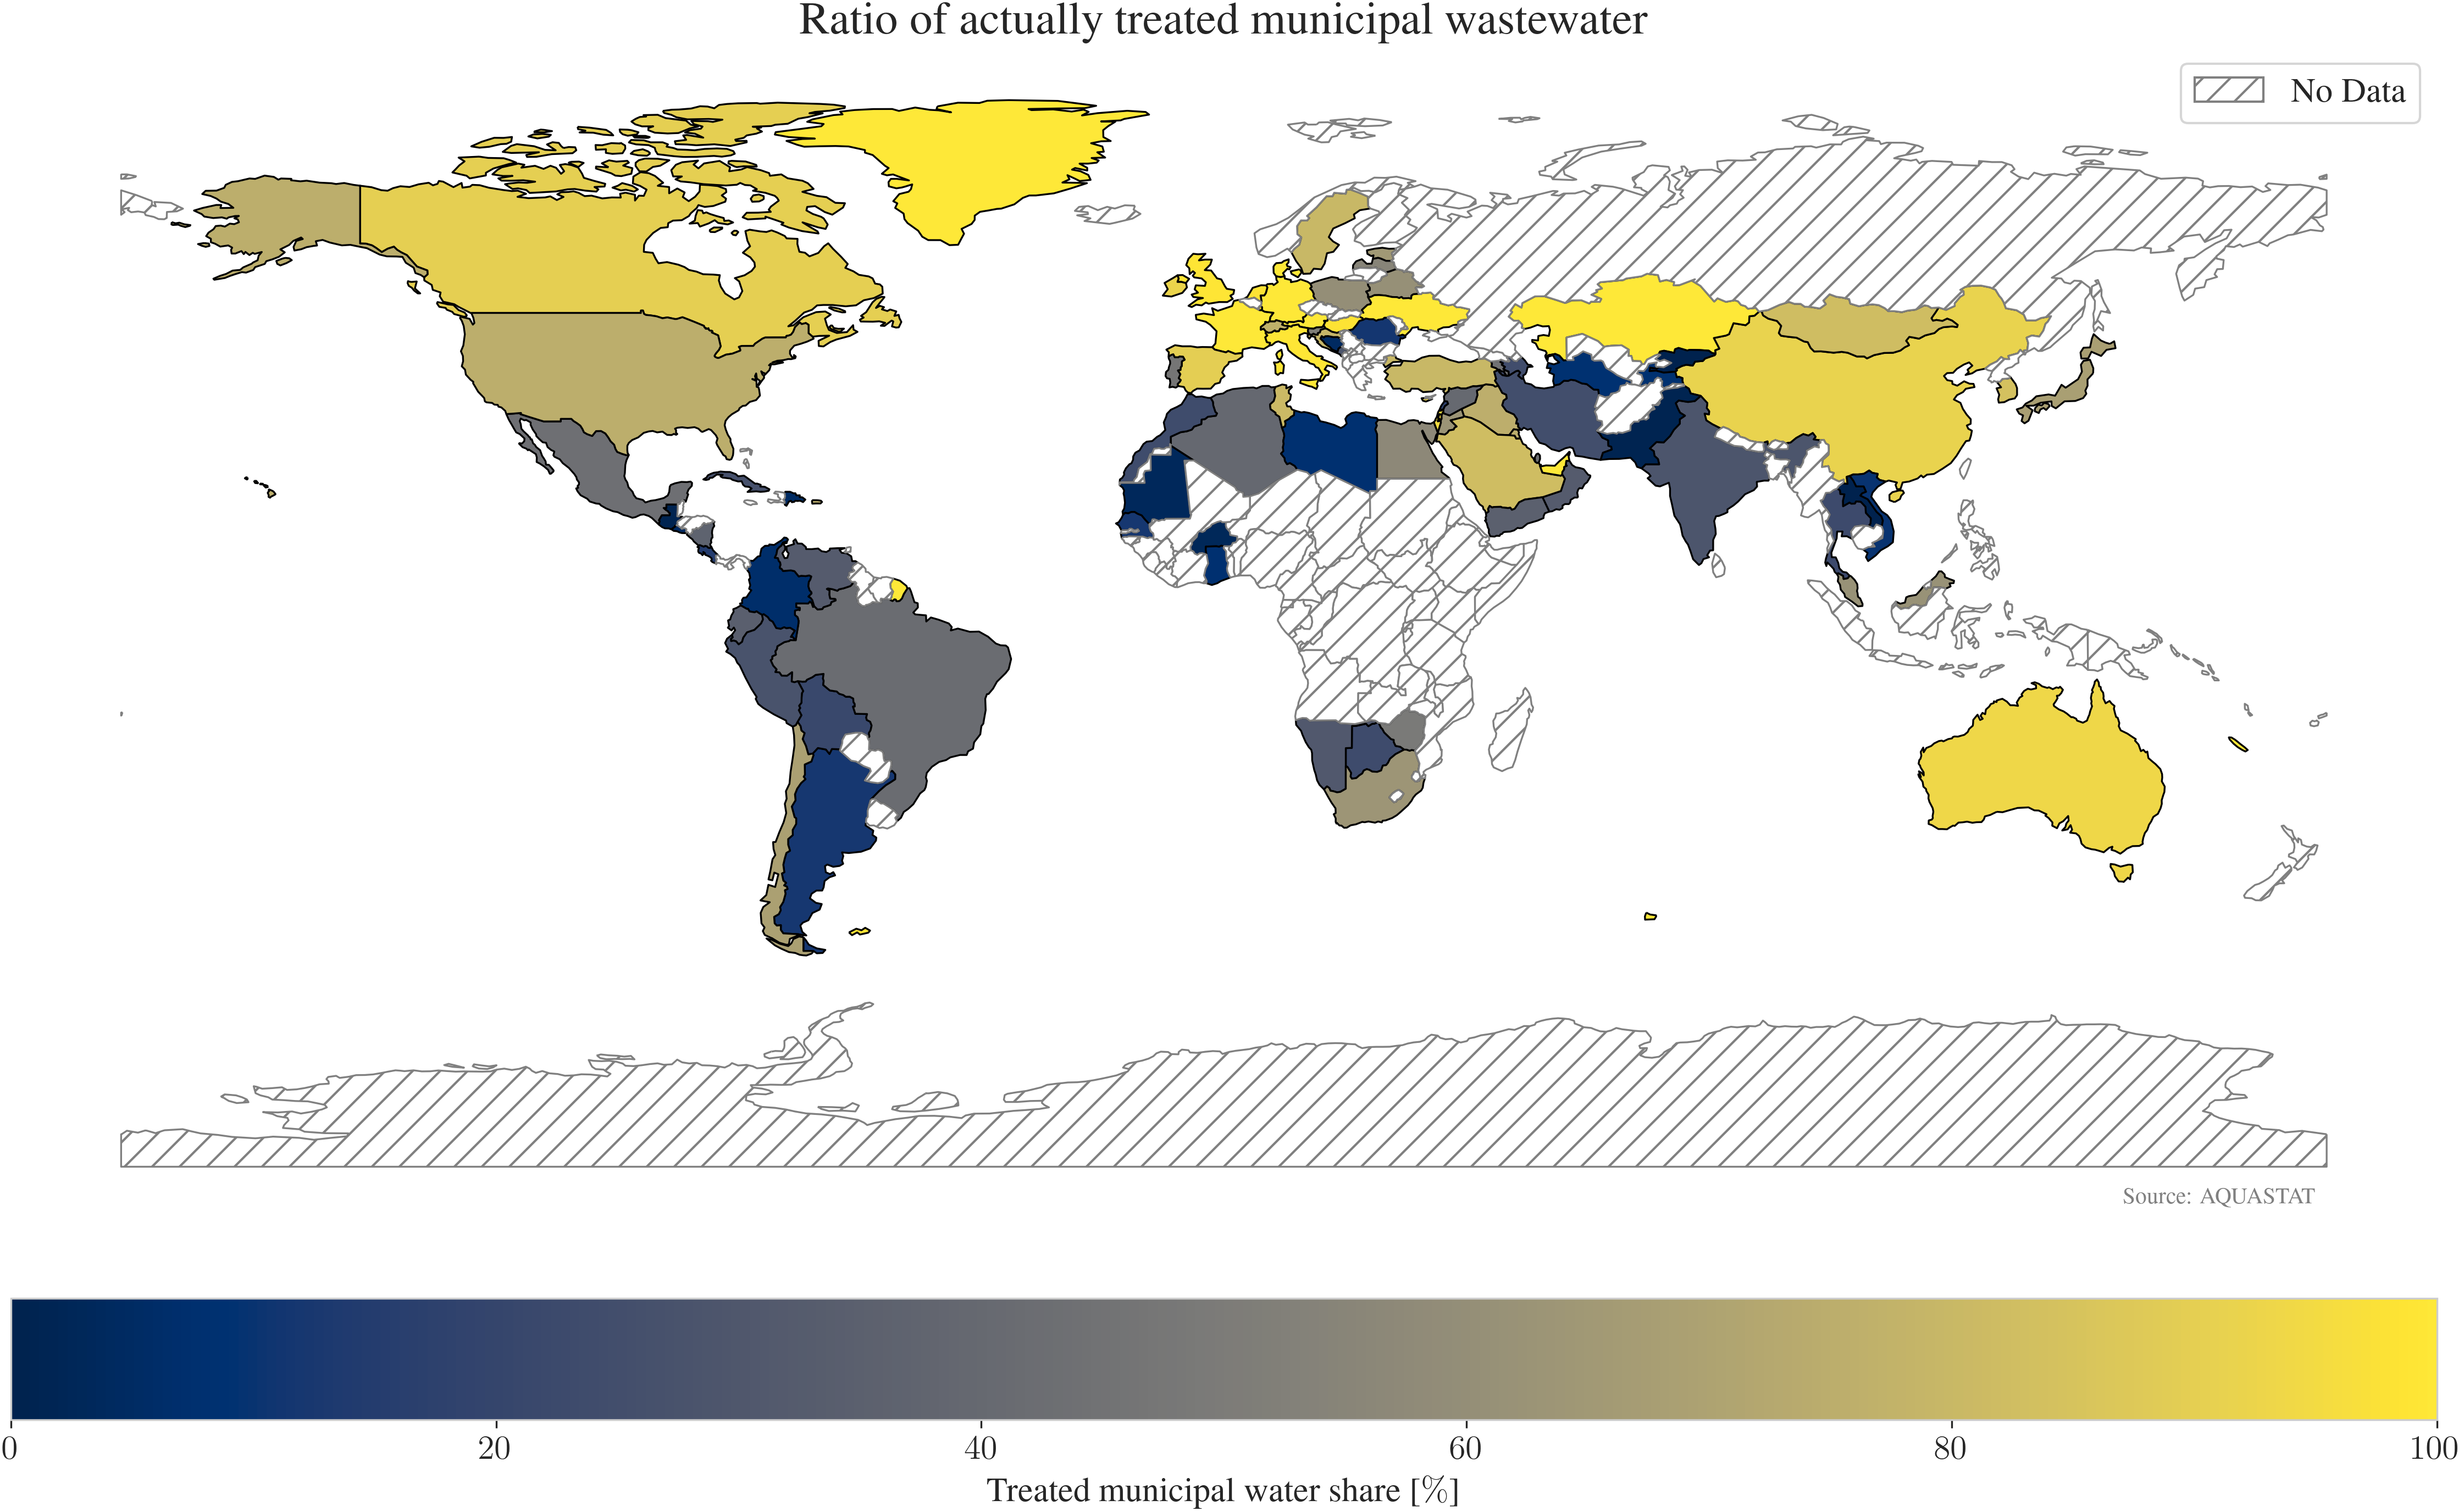

In [21]:
# Get map
world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")
# Join Data to map
merged = world.set_index('SOVEREIGNT').join(wastewater_df[wastewater_df['Year'] == 2012].set_index('Country'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plotting
merged.plot(
    column='Treated municipal water share',
    ax=ax, legend=True,
    missing_kwds={"color": "white", "edgecolor": "grey", "label": "No Data", "hatch": "//"},
    cmap='cividis',
    vmin=0, vmax=100,
    edgecolor='black',  # Add black borders for each country
    linewidth=0.8,  # Adjust line width of the borders
    legend_kwds={
        'label': "Treated municipal water share [%]",
        'orientation': "horizontal",
    }
)

# Change font sizes
cbar = fig.axes[-1]
cbar.set_xlabel('Treated municipal water share [$\%$]', fontsize=15)
for label in cbar.get_xticklabels():
    label.set_fontsize(15)

# Create a custom legend patch for "No Data"
no_data_patch = mpatches.Patch(edgecolor='grey', facecolor='white', label='No Data', hatch='//')
ax.legend(handles=[no_data_patch], loc='upper right', fontsize=15)

# Remove axis
ax.axis('off')

ax.set_title('Ratio of actually treated municipal wastewater', fontsize=20)

# Add source text
fig.text(0.95, 0.01, AQUASTAT_SOURCE,
         verticalalignment='bottom', horizontalalignment='right',
         transform=ax.transAxes,
         color='grey', fontsize=10)

C:\Users\simon\DataspellProjects\team-acqua\src\aquastat_plot.py:202: RuntimeWarning: invalid value encountered in scalar divide
  rate = ((y[-1] - y[0]) / y[0]) * 100


Saving figure to fig\water_management\fig_growth_rate_Treated_municipal_water_share.pdf ... Done!


(<Figure size 4500x3000 with 2 Axes>,
 [<Axes: title={'center': 'Growth of Treated municipal water share (2012 - 2020)'}>])

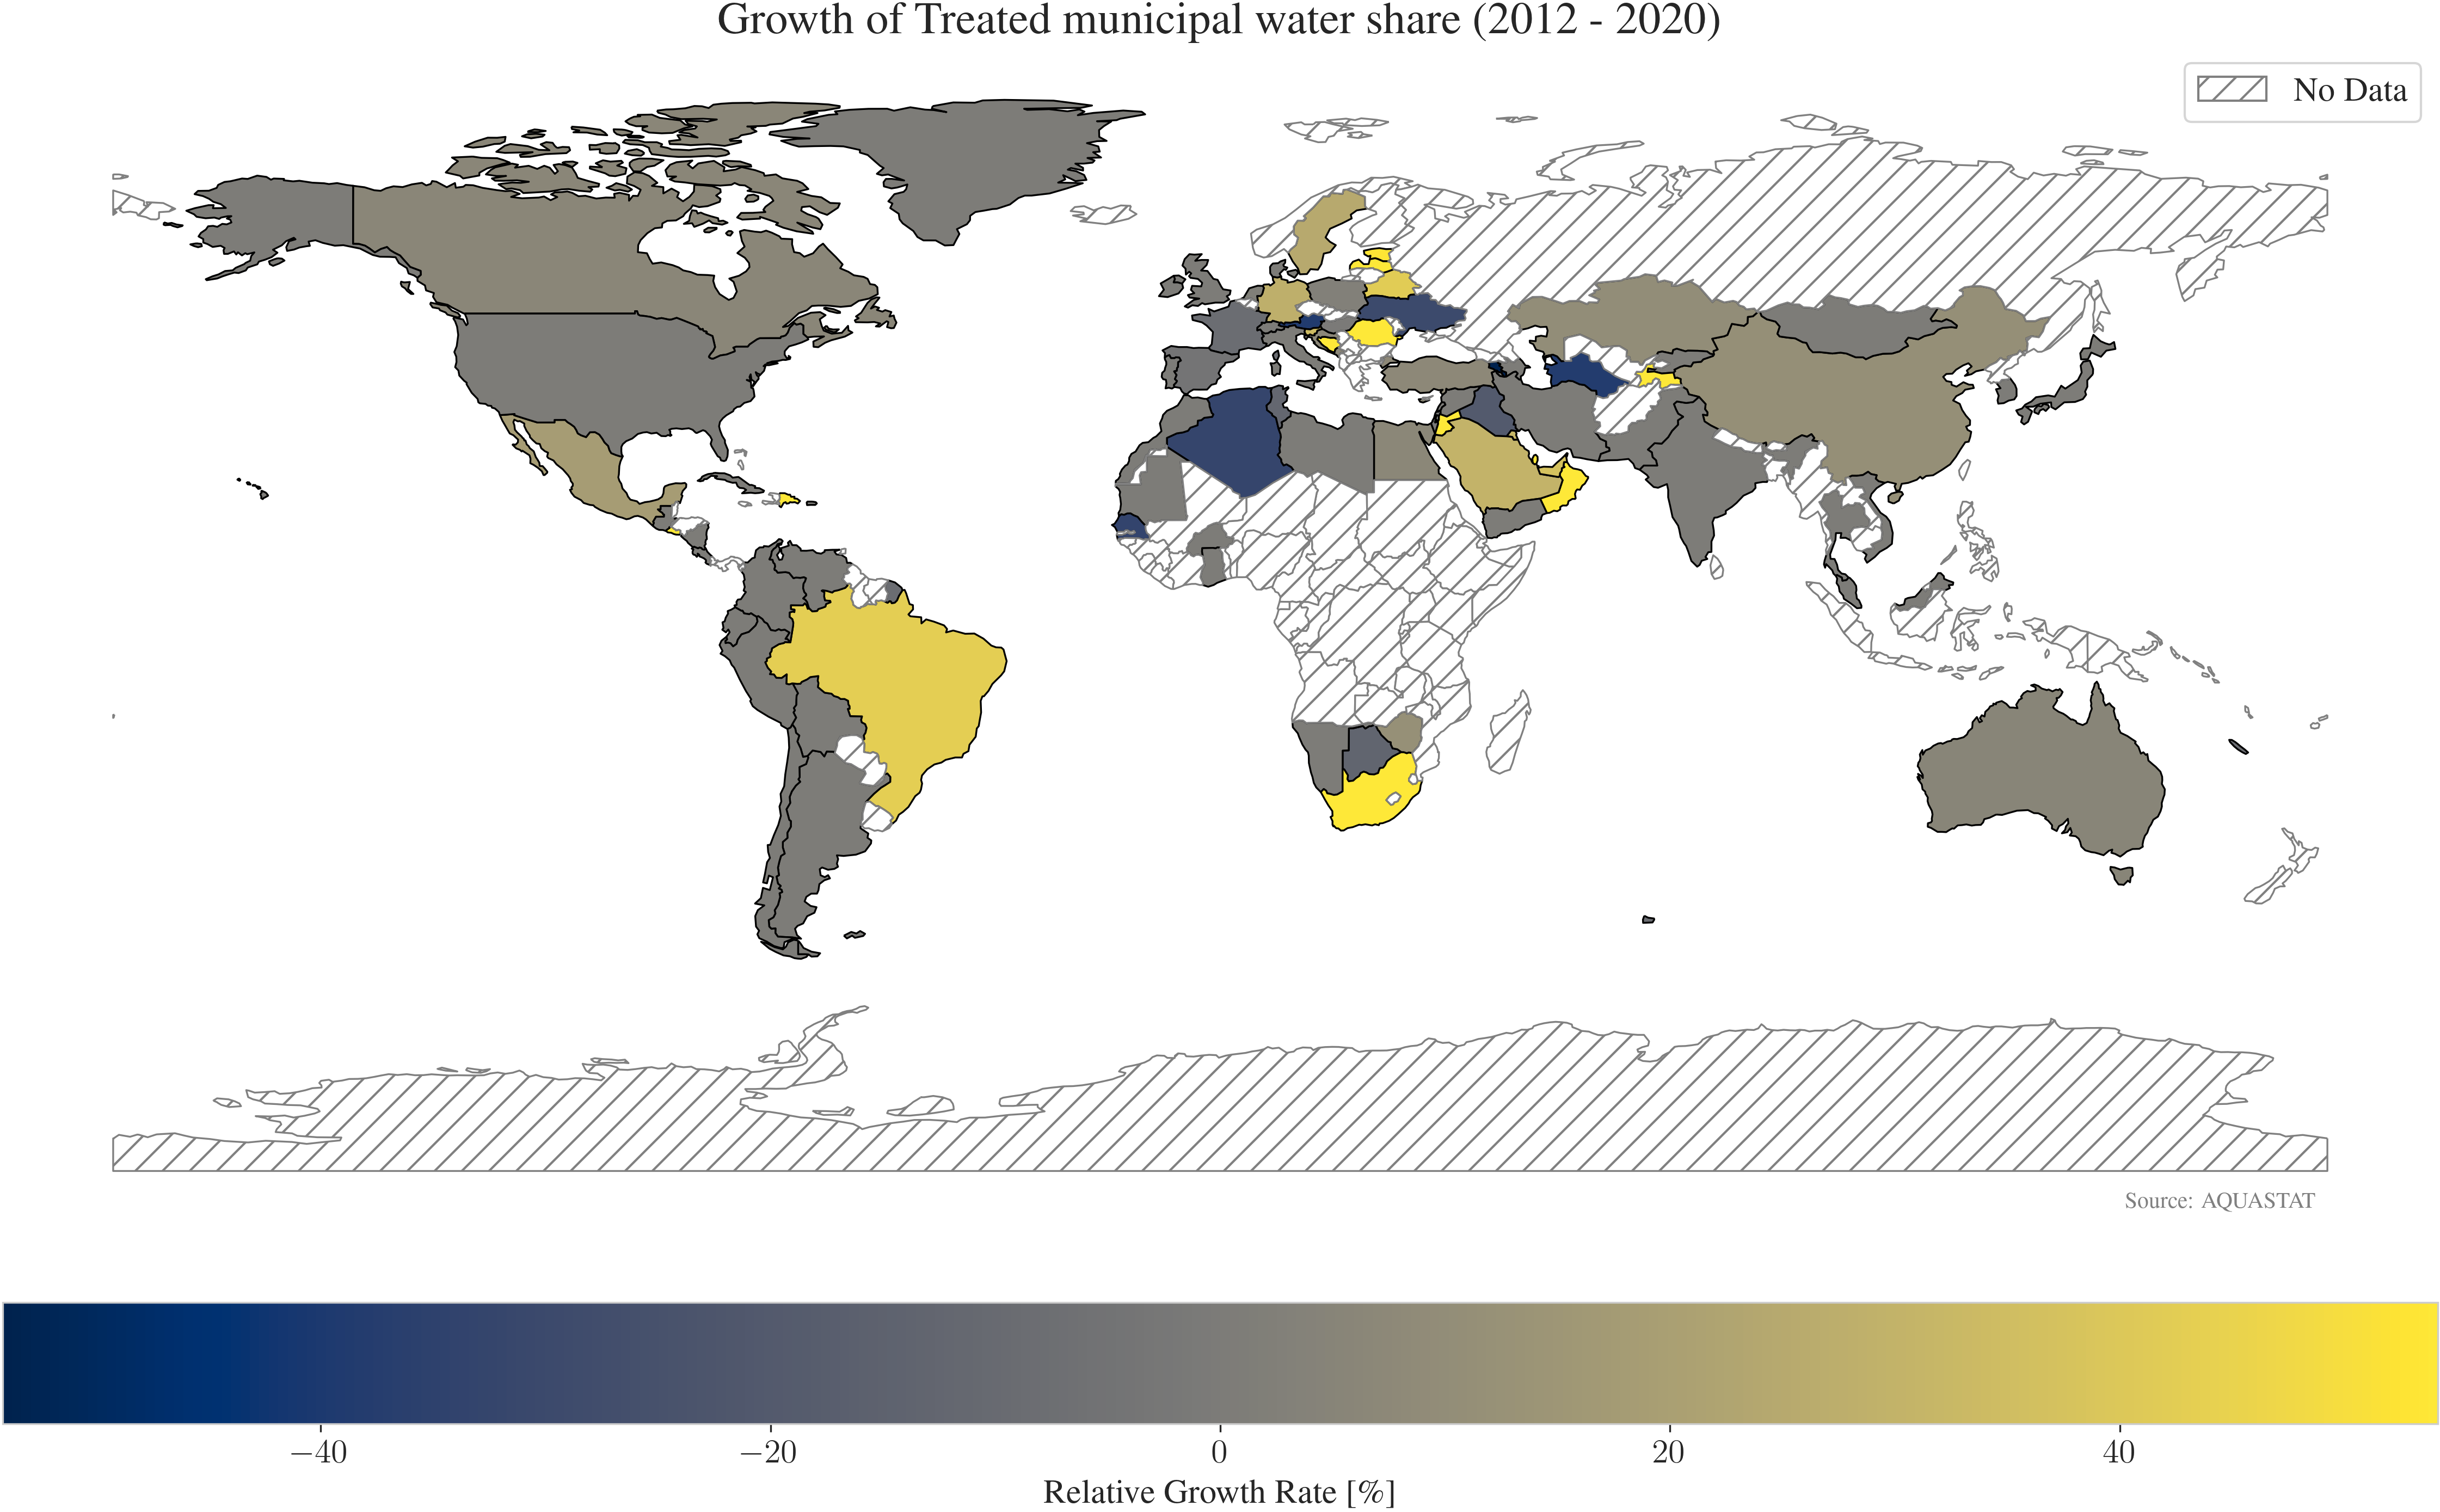

In [22]:
from src.aquastat_plot import plot_growth_rate

share_df = wastewater_df[['Treated municipal water share', 'Country', 'Year']].dropna()
share_df = share_df.pivot(index='Year', columns='Country', values='Treated municipal water share')
share_df = share_df.loc[2012:2020].dropna(axis=1)
share_df = share_df.reset_index().melt(id_vars='Year', var_name='Country', value_name='Treated municipal water share')
plot_growth_rate(share_df, 'Treated municipal water share')

### Check for connections to water stress

-0.13244190704666667
-0.47508573734000004
-0.4301927263766667
-4.017241379311667
-0.0917563905383333
-1.3632103501200008
-0.12781983178666667
-0.2589361063233333
-0.3160864316166671
-0.0065396498500000025
-0.1459224960216665
-0.005042982070000002
-0.6134681670749997
-0.20411496962500003
-0.9722589177499998
-0.272152399015
-0.1712421405683335
-0.08002809446166664
-0.40824500487833254
-0.03387829603166651
-0.304259051565
-0.03314020538499989
-0.03453330737999999
-0.14689836019333333
-0.13197591680333373
-0.03986971508166666
-0.24480773853166668
-0.36171985478666596
-0.003960003959999981
-0.009381628331666662
-0.46735709818166693
-0.045669024503333336
-0.006954372629999991
-0.13823282824833263
-1.1776891081066667
-0.8750282410183335
-0.21135670163999984
-0.013333333333333287
-8.56769444444
-0.05023666092333337
-0.03820148748833333
-0.8592399204750001
-0.009427609426666659
-0.07843357488500007
-0.4585281943766667
-0.8327666151533322
-0.3525578733733334
-18.404040404041666
Saving figure to 

(<Figure size 4500x3000 with 2 Axes>,
 [<Axes: title={'center': 'Growth of Water Stress (2012 - 2020)'}>])

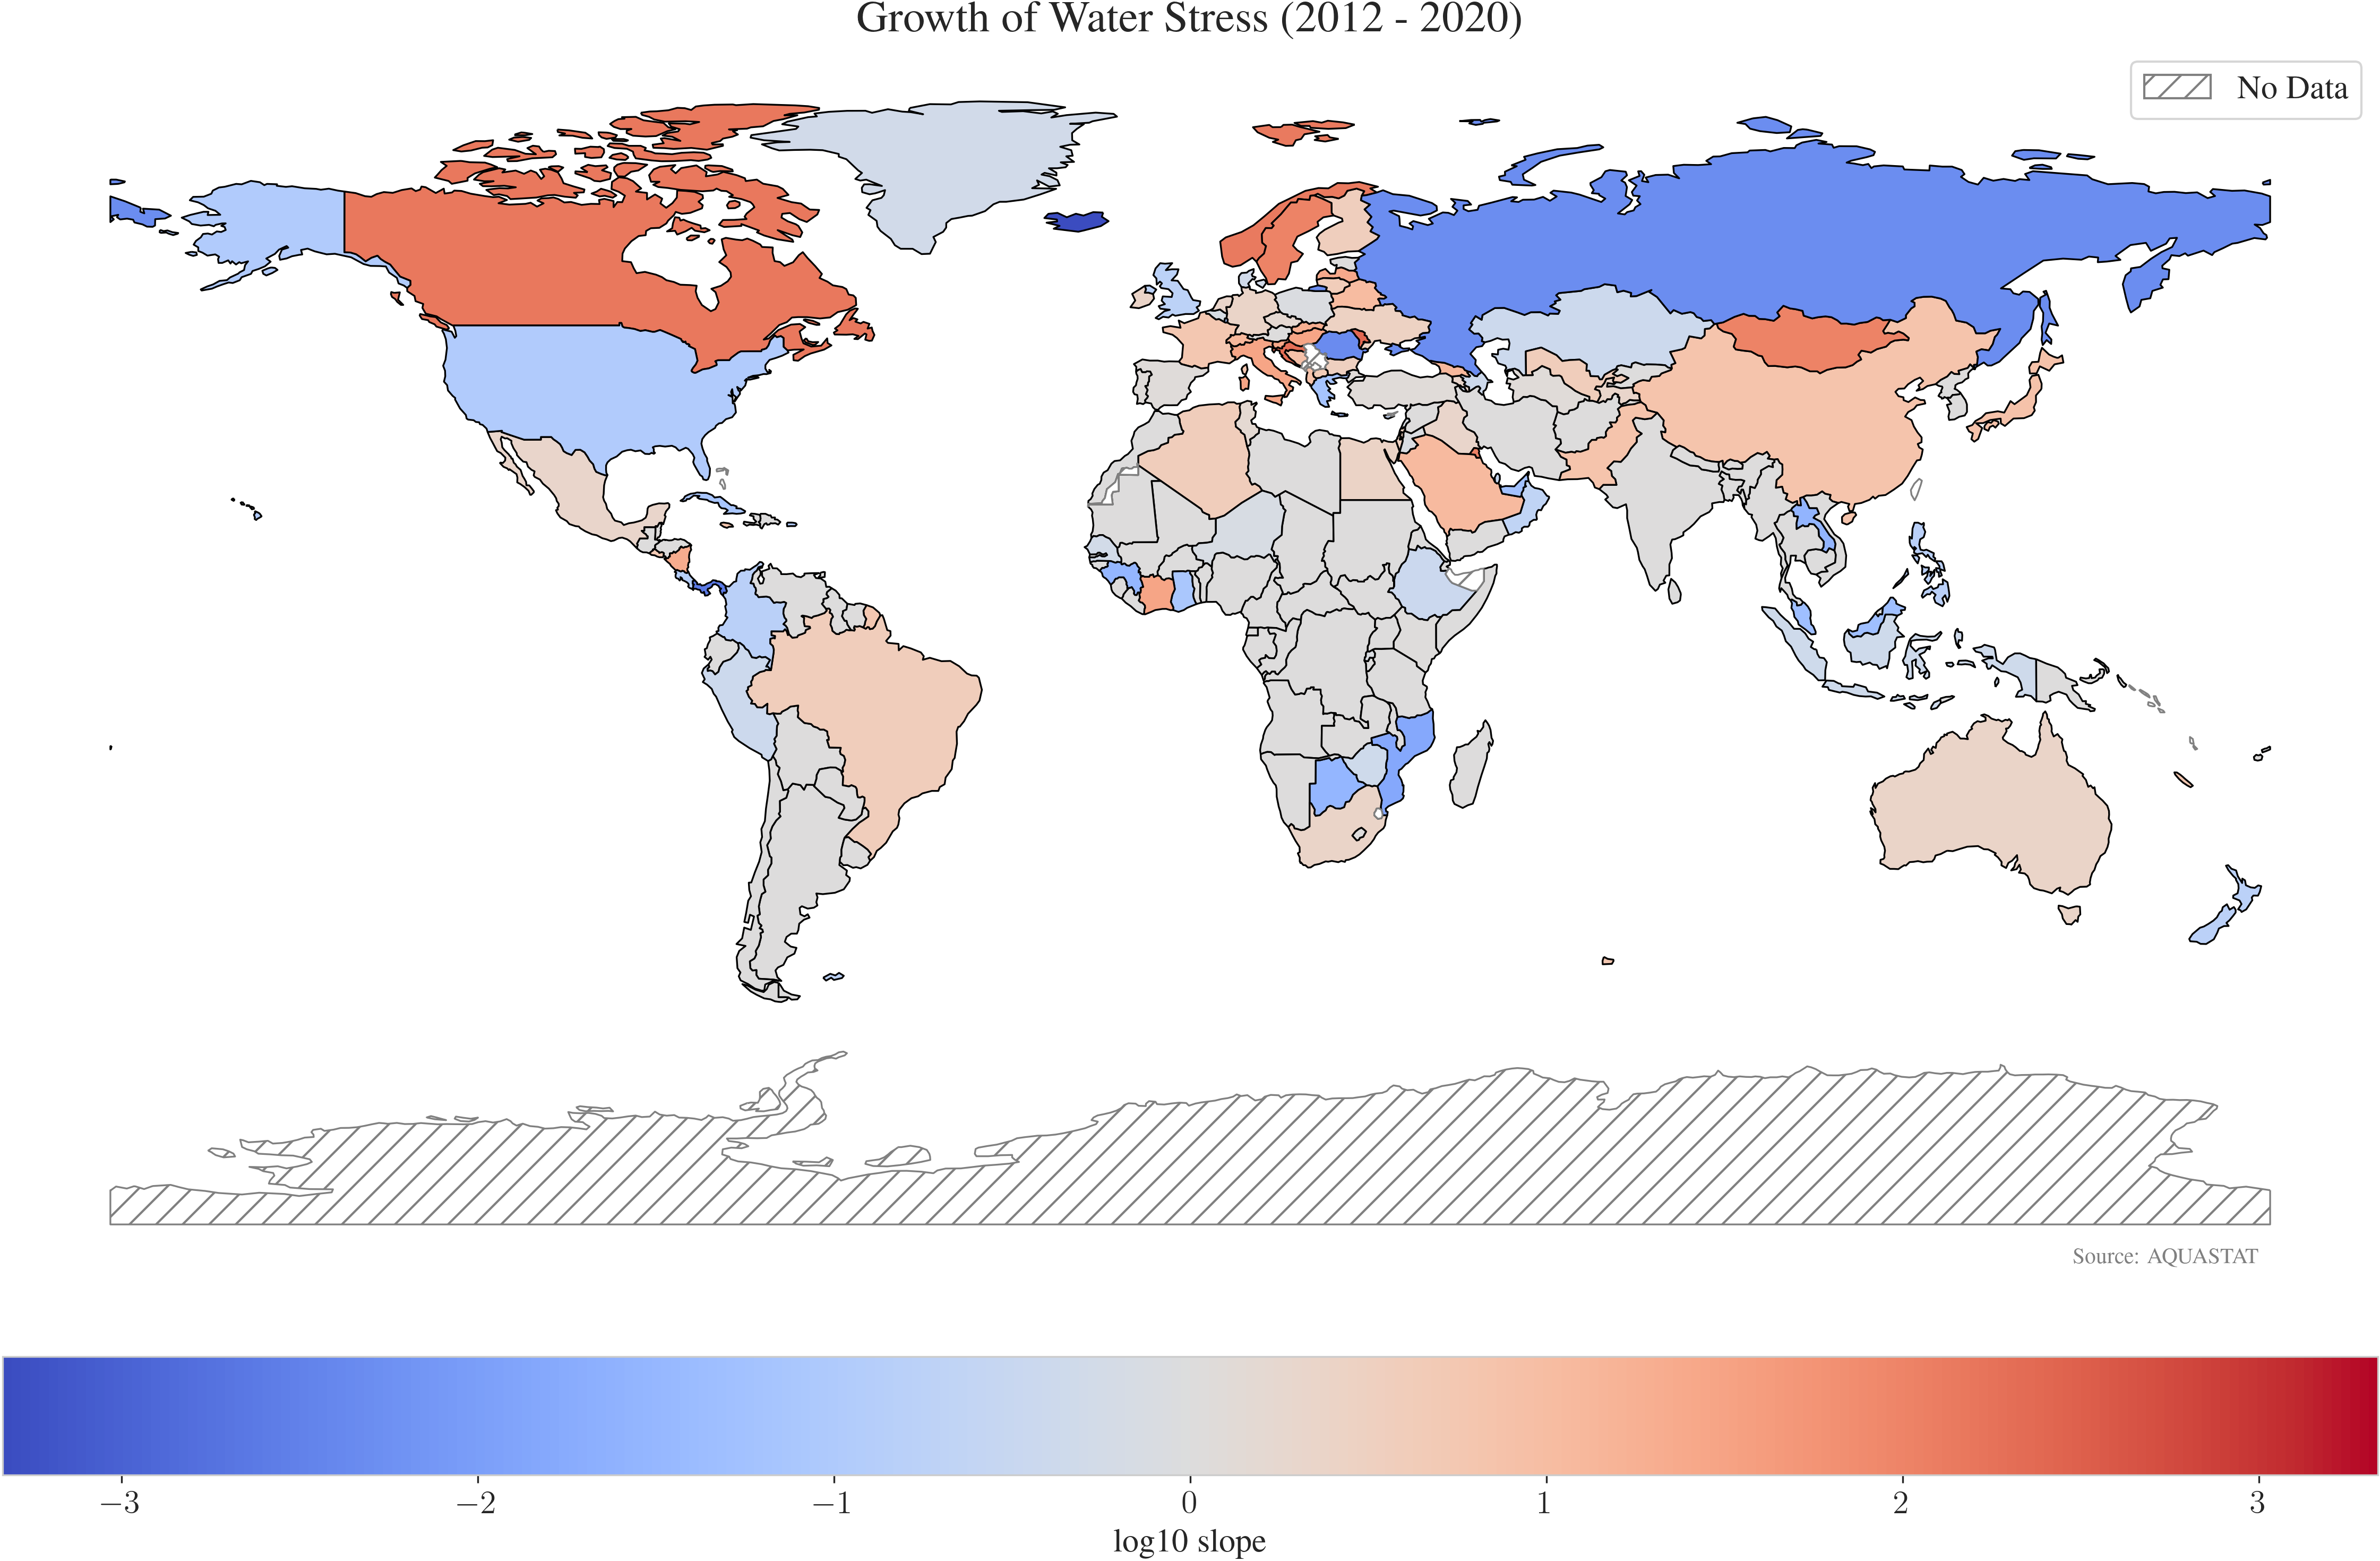

In [24]:
interesting_var = 'SDG 6.4.2. Water Stress'

stress_df = aquastat_df[['Country', 'Year', interesting_var]]
stress_df = stress_df.dropna()  # Drop rows with missing values
stress_df = stress_df.sort_values(by=interesting_var, ascending=False)  # Sort by number of facilities

plot_growth_rate(
    stress_df,
    'SDG 6.4.2. Water Stress',
    'coolwarm',
    'Water Stress',
    slope=True,
    log_scale=True
)

In [ ]:
plot_growth_rate(
    stress_df,
    'SDG 6.4.2. Water Stress',
    'coolwarm',
    'Water Stress',
    slope=False,
    log_scale=True
)